<a href="https://colab.research.google.com/github/malcolmrite-dsi/CPT-House-Predictions/blob/master/Data_Cleaning_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importing the Datasets

## Property 24 Dataset

In [ ]:
p24_df = pd.read_csv("drive/My Drive/cpt-houseprices_p24.csv")
p24_df.head()

,Description,Suburb,Price
0,2 Bedroom Apartment,Muizenberg,R 1 425 000
1,5 Bedroom House,Pinelands,R 3 200 000
2,3 Bedroom Apartment,Diep River,R 19 500 000
3,6 Bedroom House,Cape Town City Centre,R 4 495 000
4,3 Bedroom House,Kenilworth,R 6 995 000


# Data Type Changes

In [ ]:
def fixPrice(df):
  
  for i, price in enumerate(df["Price"]):
    numbers = []
    for character in str(price).split():
      if character.isdigit():
        numbers.append(character)
  
    df["Price"].iloc[i] = (''.join([str(elem) for elem in numbers]))
  return df

In [ ]:
def catDataType(data):
  for feature in data.columns:
    if data[feature].dtype == "object":
      data[feature] = data[feature].astype('category')

  return data

In [ ]:

p24_df = fixPrice(p24_df)
p24_df.head()

,Description,Suburb,Price
0,2 Bedroom Apartment,Muizenberg,1425000
1,5 Bedroom House,Pinelands,3200000
2,3 Bedroom Apartment,Diep River,19500000
3,6 Bedroom House,Cape Town City Centre,4495000
4,3 Bedroom House,Kenilworth,6995000


In [ ]:
p24_df.Price = p24_df.Price.replace('',None)

In [ ]:
p24_df.Price = p24_df.Price.astype(float)
p24_df.head()

,Description,Suburb,Price
0,2 Bedroom Apartment,Muizenberg,1425000.0
1,5 Bedroom House,Pinelands,3200000.0
2,3 Bedroom Apartment,Diep River,19500000.0
3,6 Bedroom House,Cape Town City Centre,4495000.0
4,3 Bedroom House,Kenilworth,6995000.0


In [ ]:
p24_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Description  750 non-null    category
 1   Suburb       750 non-null    category
 2   Price        750 non-null    float64 
dtypes: category(2), float64(1)
memory usage: 14.8 KB


In [ ]:
p24_df = catDataType(p24_df)

# Missing Data Code

In [ ]:
#Check Missing Values in a Dataset
def NACount(data):
  NaCount = {}
  for feature in data.columns:
    NaCount[feature] = data[feature].isna().sum()

  return NaCount

# Data Exploration

In [ ]:
p24_df.describe()

,Price
count,7.500000e+02
mean,5.533913e+06
std,1.025144e+07
min,1.990000e+05
25%,1.650000e+06
50%,2.799500e+06
75%,5.983750e+06
max,2.120000e+08


# Exploratory Data Analysis Function

In [ ]:
#Defining graphing function
def ExploreGraphs(x_feature, y_result, df, choice, custom):
  
  #Setting the visual features of the graph
  sns.set_style("darkgrid")
  plt.figure(figsize=(10,10))
  
  #Bar Chart choice
  if choice == "bar":

    barplot = sns.barplot(x = x_feature, y = y_result, data = df, ci=custom)
    plt.show()

  #Histogram choice
  elif choice == "hist":

    histplot = sns.distplot(df[x_feature])
    plt.show()

  #Count Plot Choice
  elif choice == "count":

    barplot = sns.countplot(x = x_feature, data = df)
    plt.show()

  #Heat map choice
  elif choice == "heat":

    plt.figure(figsize=(30,30))
    sns.heatmap(df.corr(), vmax=0.8, square=True, annot = True)

  #Pair plot choice
  elif choice == "pair":

    sns.pairplot(df)

  #In case the choice input is not defined in the function
  else:
    print("Not a valid choice")

# Graphing Area

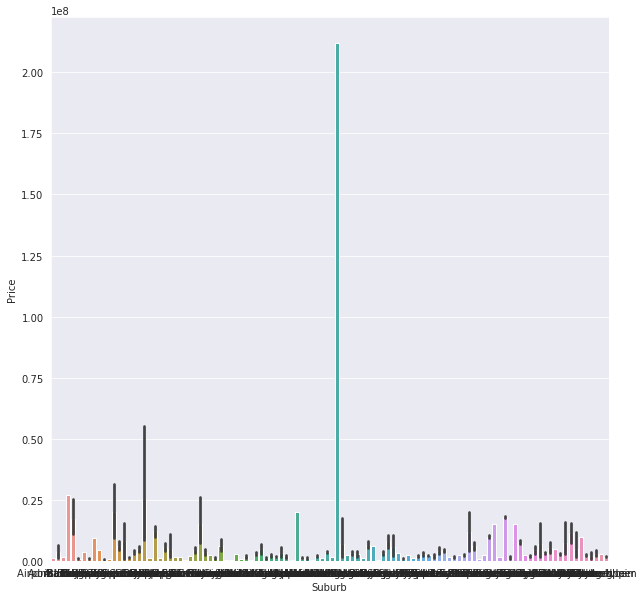

In [ ]:
'''
How to use function
FIRST PARAMETER: X Feature (Pandas Column Name)

SECOND PARAMETER: Y FEATURE (Pandas Column Name)

THIRD PARAMETER: DATA (Pandas Dataframe)

FOURTH PARAMETER: Choice of graph: "bar" for Bar Plot (Good for comparing one insurance product with a feature),
                                    "hist" for Histogram (Good for continuous distrbution of one feature),
                                    "count" for a count plot (Good for the discontinuous distribution of one feature),
                                    "heat" for a heatmap between the variables of the dataset,
                                    "pair" for a pairplot between the variables of a dataset (Be careful of the number of features you're comparing)

FIFTH PARAMETER: Confidence Interval error bar for Bar Plot = number (number% Confidence Interval), None (No error bar) 
'''
ExploreGraphs("Suburb", "Price", p24_df, "bar", 95)